In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from tensorflow.keras.metrics import RootMeanSquaredError
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import *
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score
import tensorflow as tf
color_pal = sns.color_palette()
plt.style.use('dark_background')

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13568290/13568290 [==============================] - 0s 0us/step


In [3]:
df = pd.read_csv(csv_path)
df.head()

In [4]:
df.shape

(420551, 15)

In [5]:
df['Date Time'] = pd.to_datetime(df['Date Time'])
df = df.set_index('Date Time')

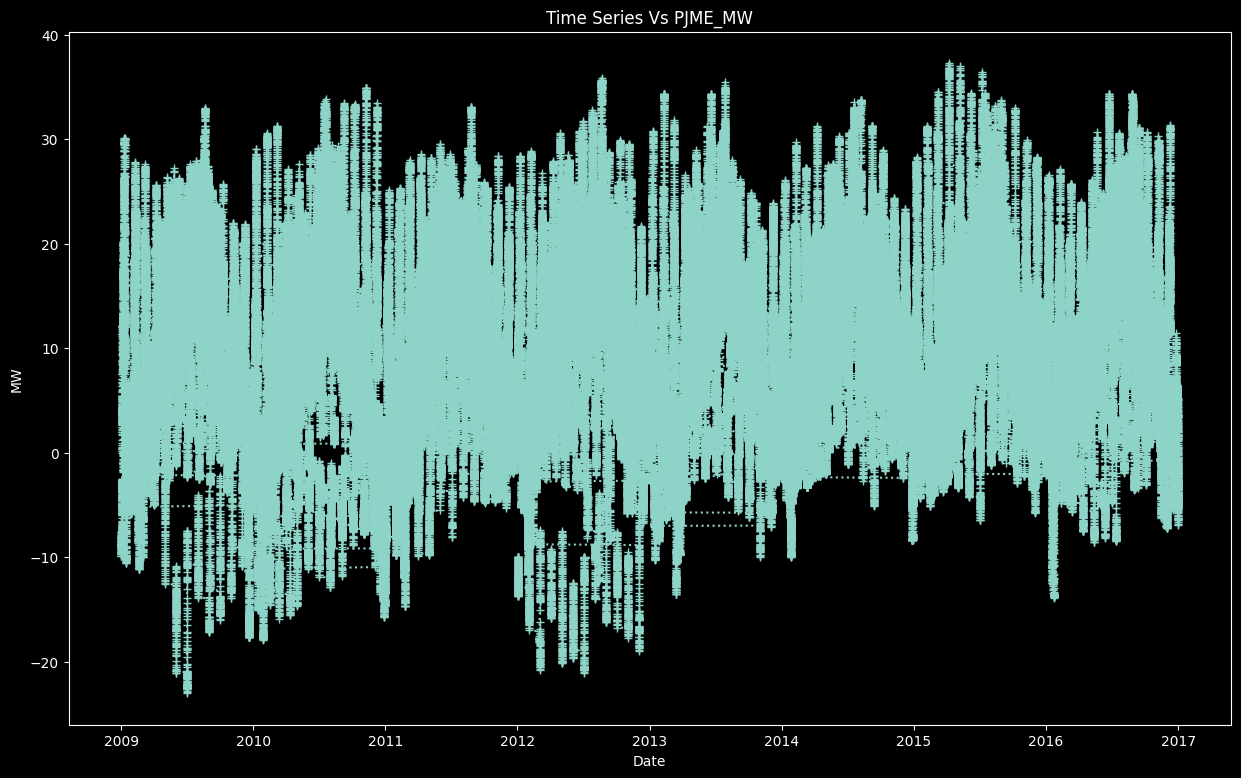

In [6]:
plt.figure(figsize=(15, 9))
plt.plot(df.index, df['T (degC)'], marker='+', linestyle=':')
plt.title('Time Series Vs PJME_MW')
plt.xlabel('Date')
plt.ylabel('MW')
plt.show()

In [36]:
weekdata = df.iloc[(df.index>'01-01-2009') & (df.index<'01-08-2009')].sort_index()

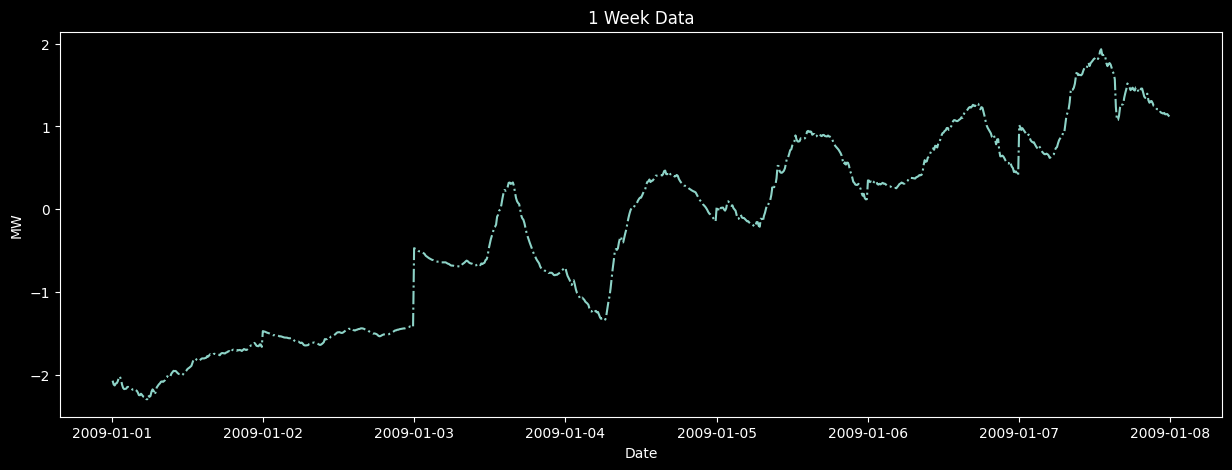

In [37]:
plt.figure(figsize=(15, 5))
plt.plot(weekdata.index, weekdata['T (degC)'], marker='', linestyle='-.')
plt.title('1 Week Data')
plt.xlabel('Date')
plt.ylabel('MW')
plt.show()

In [38]:
daydata = df.iloc[(df.index>'01-04-2009') & (df.index<'01-05-2009')].sort_index()

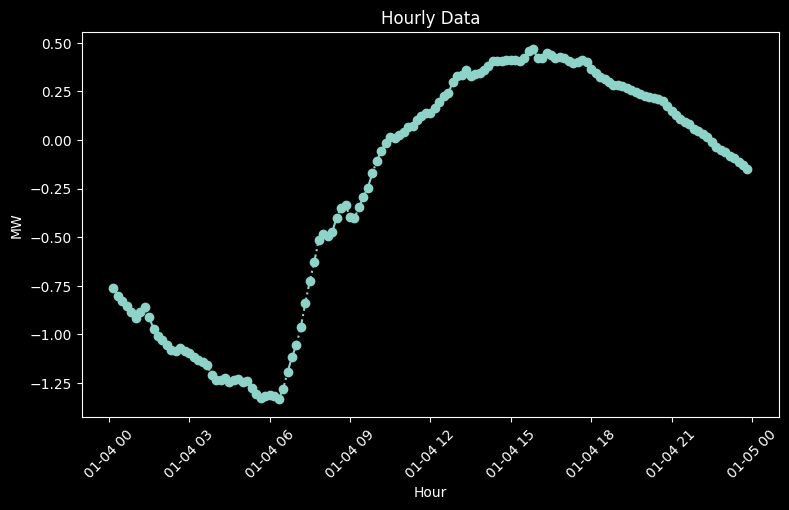

In [39]:
plt.figure(figsize=(9, 5))
plt.plot(daydata.index, daydata['T (degC)'], marker='o', linestyle='-.')
plt.xticks(rotation=45)
plt.title('Hourly Data')
plt.xlabel('Hour')
plt.ylabel('MW')
plt.show()

In [40]:
FirstQu = df.iloc[(df.index>'01-01-2009') & (df.index<'04-01-2009')].sort_index()
SecondQu = df.iloc[(df.index>'04-01-2009') & (df.index<'07-01-2009')].sort_index()
ThirdQu = df.iloc[(df.index>'07-01-2009') & (df.index<'10-01-2009')].sort_index()
LastQu = df.iloc[(df.index>'10-01-2009') & (df.index<'01-01-2010')].sort_index()

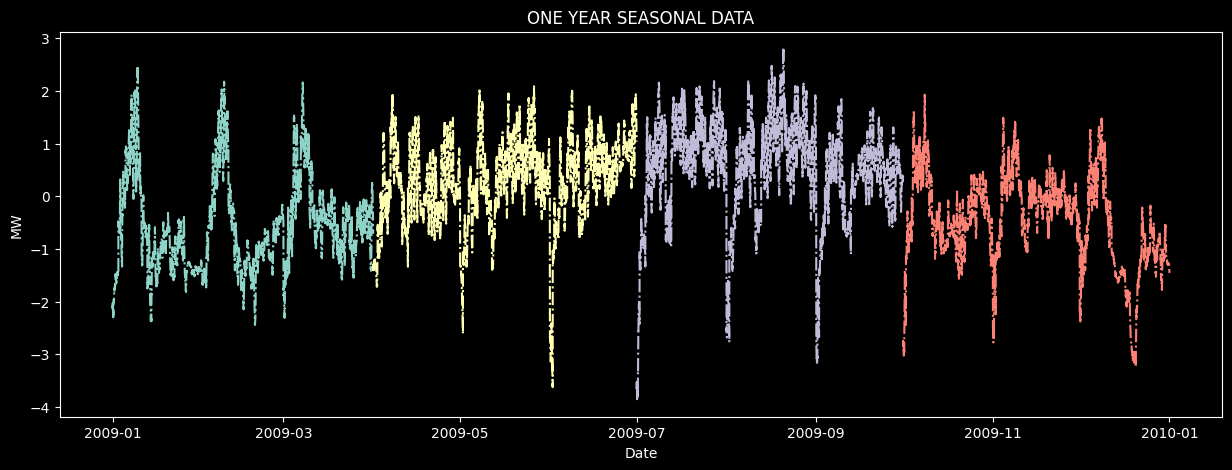

In [41]:
plt.figure(figsize=(15, 5))
plt.plot(FirstQu.index, FirstQu['T (degC)'], marker='', linestyle='-.')
plt.plot(SecondQu.index, SecondQu['T (degC)'], marker='', linestyle='-.')
plt.plot(ThirdQu.index, ThirdQu['T (degC)'], marker='', linestyle='-.')
plt.plot(LastQu.index, LastQu['T (degC)'], marker='', linestyle='-.')
plt.title('ONE YEAR SEASONAL DATA')
plt.xlabel('Date')
plt.ylabel('MW')
plt.show()

In [42]:
def feature_creation(df):
  df['hour'] = df.index.hour
  df['dayofweek'] = df.index.day_of_week
  df['dayofyear'] = df.index.day_of_year
  df['quarter'] = df.index.quarter
  df['month'] = df.index.month
  df['year'] = df.index.year
  return df

In [43]:
df1 = feature_creation(df)
df1

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),hour,dayofweek,dayofyear,quarter,month,year
Date Time,,,,,,,,,,,,,,,,,,,,
2009-01-01 00:10:00,0.874229,-2.074010,-2.127439,-2.058613,1.049500,-1.323973,-1.535254,-0.780586,-1.536971,-1.539461,2.293603,-0.010271,-0.018931,-0.258921,0,3,1,1,1,2009
2009-01-01 00:20:00,0.880211,-2.120310,-2.173297,-2.115071,1.055569,-1.336894,-1.556764,-0.782628,-1.555795,-1.560710,2.344885,-0.015008,-0.022553,-0.445812,0,3,1,1,1,2009
2009-01-01 00:30:00,0.875425,-2.132182,-2.185056,-2.119528,1.085916,-1.339478,-1.559154,-0.784670,-1.559560,-1.563071,2.355891,-0.023106,-0.035159,-0.036268,0,3,1,1,1,2009
2009-01-01 00:40:00,0.873032,-2.108438,-2.160363,-2.083871,1.104124,-1.333018,-1.544814,-0.786712,-1.544501,-1.548905,2.329625,-0.020814,-0.037042,0.268295,0,3,1,1,1,2009
2009-01-01 00:50:00,0.873032,-2.103690,-2.156835,-2.079413,1.098055,-1.331726,-1.542424,-0.786712,-1.544501,-1.546544,2.324872,-0.021120,-0.035159,0.456339,0,3,1,1,1,2009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 23:20:00,1.298947,-1.602702,-1.692374,-1.944211,-0.176513,-1.170206,-1.489845,-0.576373,-1.491793,-1.496962,1.924124,-0.015772,-0.022263,0.752826,23,5,366,4,12,2016
2016-12-31 23:30:00,1.282198,-1.519600,-1.608888,-1.933811,-0.382265,-1.137903,-1.485065,-0.531446,-1.488028,-1.492239,1.835569,-0.008591,-0.016468,0.687069,23,5,366,4,12,2016
2016-12-31 23:40:00,1.269037,-1.497044,-1.585371,-1.956097,-0.491513,-1.128857,-1.494625,-0.508983,-1.495557,-1.501684,1.809303,-0.009507,-0.015309,0.466722,23,5,366,4,12,2016


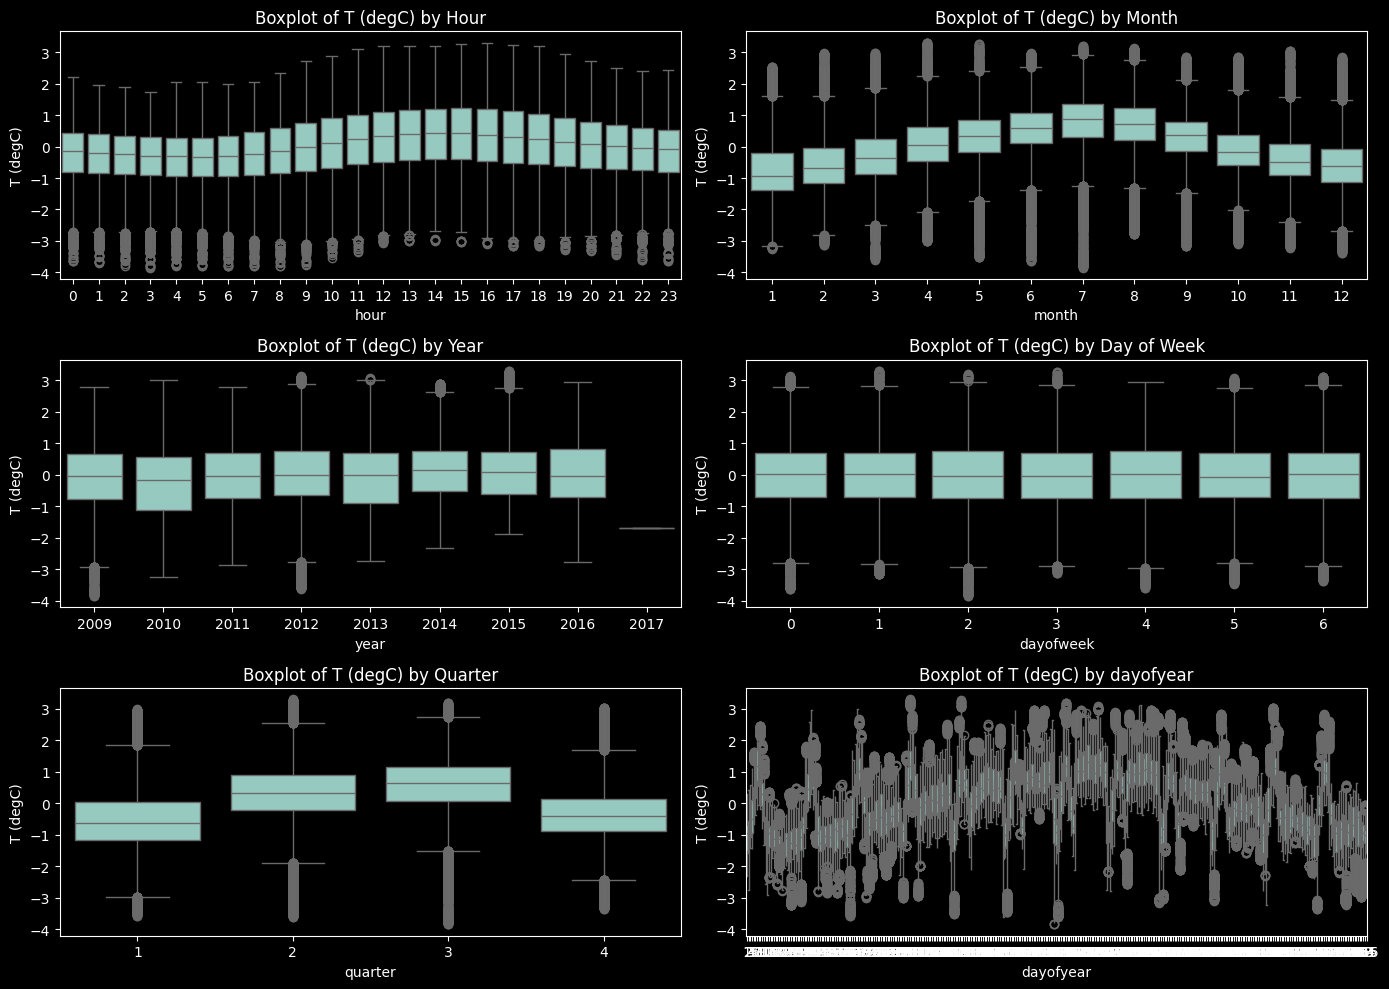

In [44]:
params = [
    {'x': 'hour', 'title': 'Boxplot of T (degC) by Hour'},
    {'x': 'month', 'title': 'Boxplot of T (degC) by Month'},
    {'x': 'year', 'title': 'Boxplot of T (degC) by Year'},
    {'x': 'dayofweek', 'title': 'Boxplot of T (degC) by Day of Week'},
    {'x': 'quarter', 'title': 'Boxplot of T (degC) by Quarter'},
    {'x': 'dayofyear', 'title': 'Boxplot of T (degC) by dayofyear'}
]
custom_palette = sns.color_palette("husl", len(params))
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 10))
axes = axes.flatten()

for i, param in enumerate(params):
    sns.boxplot(data=df1, x=param['x'], y='T (degC)', ax=axes[i])
    axes[i].set_title(param['title'])

plt.tight_layout()
plt.show()

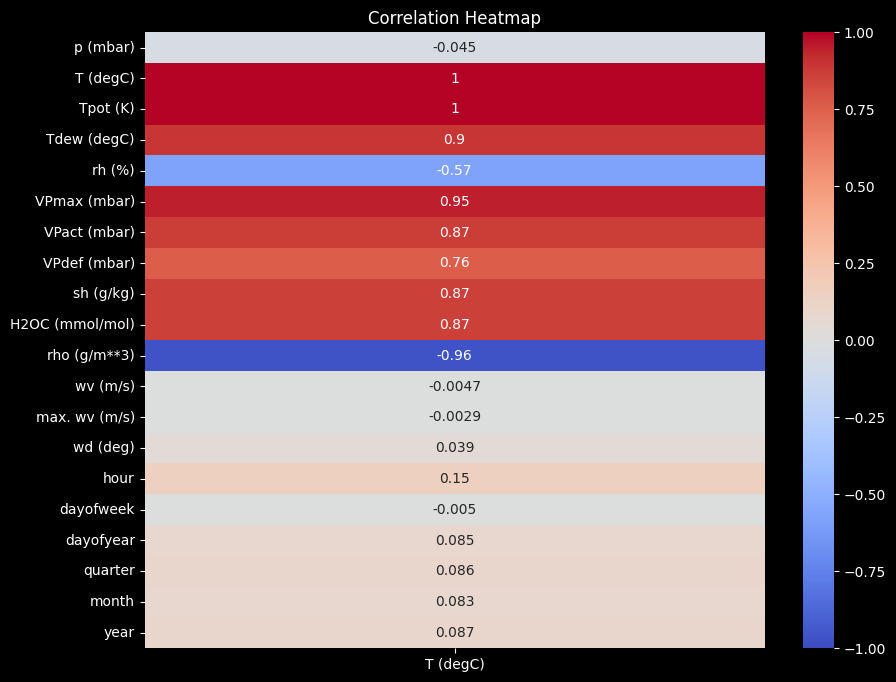

In [50]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix[['T (degC)']], annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

In [51]:
df.columns

Index(['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)',
       'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)', 'hour', 'dayofweek', 'dayofyear', 'quarter', 'month',
       'year'],
      dtype='object')

In [54]:
feature_column = ['p (mbar)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)','VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)','H2OC (mmol/mol)', 'rho (g/m**3)']
target_column = 'T (degC)'
all_column = feature_column + [target_column]

In [55]:
df.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),hour,dayofweek,dayofyear,quarter,month,year
count,4.205510e+05,4.205510e+05,4.205510e+05,4.205510e+05,4.205510e+05,4.205510e+05,4.205510e+05,4.205510e+05,4.205510e+05,4.205510e+05,4.205510e+05,4.205510e+05,4.205510e+05,4.205510e+05,420551.00000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000
mean,5.623045e-14,9.515556e-17,4.247398e-15,-3.243940e-17,2.265351e-16,2.141000e-16,4.217122e-16,6.163485e-17,-5.428192e-16,-4.325253e-18,5.323305e-15,2.880686e-18,-6.458312e-18,-8.596440e-17,11.50037,3.001945,182.876562,2.505691,6.515264,2012.496813
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,6.92172,1.999634,105.461230,1.117081,3.449824,2.289760
min,-9.046234e+00,-3.853584e+00,-3.867700e+00,-4.452133e+00,-3.827239e+00,-1.631505e+00,-2.089726e+00,-8.255125e-01,-2.079111e+00,-2.087225e+00,-3.917747e+00,-1.528068e+02,-1.449218e+02,-2.015924e+00,0.00000,0.000000,1.000000,1.000000,1.000000,2009.000000
25%,-5.997234e-01,-7.230064e-01,-7.128889e-01,-7.006510e-01,-6.553863e-01,-7.489644e-01,-7.943655e-01,-6.478473e-01,-7.915280e-01,-7.910061e-01,-7.147617e-01,-1.088250e-02,-1.878605e-02,-5.750204e-01,6.00000,1.000000,91.000000,2.000000,4.000000,2010.000000
50%,4.393429e-02,-3.579015e-03,-2.674293e-03,3.924513e-02,1.997879e-01,-2.269345e-01,-1.610252e-01,-3.782863e-01,-1.627958e-01,-1.606044e-01,-5.685394e-02,8.827969e-04,-1.399008e-03,2.694486e-01,12.00000,3.000000,183.000000,3.000000,7.000000,2012.000000
75%,6.588786e-01,7.146612e-01,7.098920e-01,7.598267e-01,8.127942e-01,5.199301e-01,6.730721e-01,2.568157e-01,6.692390e-01,6.728480e-01,6.680954e-01,1.769036e-02,2.439176e-02,6.847612e-01,17.00000,5.000000,274.000000,4.000000,10.000000,2014.000000
max,3.127030e+00,3.303888e+00,3.274425e+00,2.697225e+00,1.456147e+00,6.485802e+00,4.489844e+00,8.570322e+00,4.558343e+00,4.528451e+00,4.439683e+00,4.093067e-01,2.962091e-01,2.137202e+00,23.00000,6.000000,366.000000,4.000000,12.000000,2017.000000


In [56]:
df = (df - df.mean()) / df.std()

In [57]:
df.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),hour,dayofweek,dayofyear,quarter,month,year
count,4.205510e+05,4.205510e+05,4.205510e+05,4.205510e+05,4.205510e+05,4.205510e+05,4.205510e+05,4.205510e+05,4.205510e+05,4.205510e+05,4.205510e+05,4.205510e+05,4.205510e+05,4.205510e+05,4.205510e+05,4.205510e+05,4.205510e+05,4.205510e+05,4.205510e+05,4.205510e+05
mean,1.081313e-17,2.919546e-17,-5.406566e-18,-3.243940e-17,-8.650506e-18,3.135808e-17,1.730101e-17,-1.946364e-17,5.406566e-18,-2.595152e-17,-1.946364e-17,1.364313e-18,1.436119e-19,-1.649003e-17,-4.479002e-17,1.590882e-16,7.785455e-17,2.811414e-17,1.254323e-16,-1.531140e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-9.046234e+00,-3.853584e+00,-3.867700e+00,-4.452133e+00,-3.827239e+00,-1.631505e+00,-2.089726e+00,-8.255125e-01,-2.079111e+00,-2.087225e+00,-3.917747e+00,-1.528068e+02,-1.449218e+02,-2.015924e+00,-1.661490e+00,-1.501247e+00,-1.724582e+00,-1.347880e+00,-1.598709e+00,-1.527153e+00
25%,-5.997234e-01,-7.230064e-01,-7.128889e-01,-7.006510e-01,-6.553863e-01,-7.489644e-01,-7.943655e-01,-6.478473e-01,-7.915280e-01,-7.910061e-01,-7.147617e-01,-1.088250e-02,-1.878605e-02,-5.750204e-01,-7.946536e-01,-1.001156e+00,-8.711880e-01,-4.526898e-01,-7.290994e-01,-1.090426e+00
50%,4.393429e-02,-3.579015e-03,-2.674293e-03,3.924513e-02,1.997879e-01,-2.269345e-01,-1.610252e-01,-3.782863e-01,-1.627958e-01,-1.606044e-01,-5.685394e-02,8.827969e-04,-1.399008e-03,2.694486e-01,7.218297e-02,-9.727116e-04,1.170459e-03,4.425001e-01,1.405102e-01,-2.169715e-01
75%,6.588786e-01,7.146612e-01,7.098920e-01,7.598267e-01,8.127942e-01,5.199301e-01,6.730721e-01,2.568157e-01,6.692390e-01,6.728480e-01,6.680954e-01,1.769036e-02,2.439176e-02,6.847612e-01,7.945468e-01,9.992103e-01,8.640468e-01,1.337690e+00,1.010120e+00,6.564826e-01
max,3.127030e+00,3.303888e+00,3.274425e+00,2.697225e+00,1.456147e+00,6.485802e+00,4.489844e+00,8.570322e+00,4.558343e+00,4.528451e+00,4.439683e+00,4.093067e-01,2.962091e-01,2.137202e+00,1.661383e+00,1.499302e+00,1.736405e+00,1.337690e+00,1.589859e+00,1.966664e+00


In [58]:
split_fraction = 0.9
train_test_split = int(split_fraction * int(df.shape[0]))
train_test_split

378495

In [59]:
train = df.iloc[0: train_test_split - 1][all_column]
test = df.iloc[train_test_split :][all_column]

In [61]:
sample_rate = 6 # as data is recorded at difference of 10 minutes so we are only choosing data from each hour
past = 720 # we are collecting data of past 720 stamps= 720/6=120 hours = 5 days
future = 72 #and we will predict 12 hours after of current stamps===>> 72 stamps = 72 /6 = 12 hours

In [62]:
start = past + future
end = start + train_test_split

X_train = train.values
y_train = df['T (degC)'].iloc[start:end-1].values

In [63]:
print(X_train.shape)
print(y_train.shape)

(378494, 11)
(378494,)


In [64]:
sequence_length = int(past / sample_rate)
sequence_length

120

In [65]:
import tensorflow as tf
from tensorflow import keras


dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=sample_rate,
    batch_size=256,
)

In [66]:
x_end = len(test) - past - future
label_start = train_test_split + past + future

In [67]:
X_test = test[:x_end].values
y_test = df['T (degC)'].iloc[label_start:].values

In [68]:
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    X_test,
    y_test,
    sequence_length=sequence_length,
    sampling_rate=sample_rate,
    batch_size=256,
)

In [69]:
for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 120, 11)
Target shape: (256,)


In [70]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 11)]         0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                5632      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5665 (22.13 KB)
Trainable params: 5665 (22.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


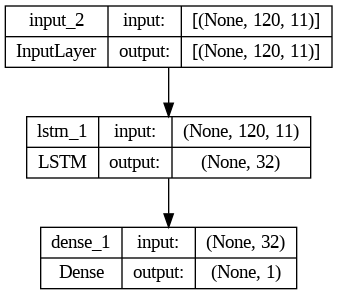

In [71]:
model.compile(loss='mse', optimizer=Adam(),metrics=[RootMeanSquaredError()])
cp = ModelCheckpoint('model',save_best_only=True)
plot_model(model, show_shapes=True)

In [72]:
history = model.fit(
    dataset_train,
    epochs=10,
    validation_data=dataset_val,
    callbacks=[cp],
)

Epoch 1/10
1476/1476 [==============================] - 57s 37ms/step - loss: 0.2027 - root_mean_squared_error: 0.4502 - val_loss: 0.1862 - val_root_mean_squared_error: 0.4315
Epoch 2/10
1476/1476 [==============================] - 54s 37ms/step - loss: 0.1341 - root_mean_squared_error: 0.3663 - val_loss: 0.1380 - val_root_mean_squared_error: 0.3715
Epoch 3/10
1476/1476 [==============================] - 51s 34ms/step - loss: 0.1240 - root_mean_squared_error: 0.3521 - val_loss: 0.1400 - val_root_mean_squared_error: 0.3742
Epoch 4/10
1476/1476 [==============================] - 55s 38ms/step - loss: 0.1211 - root_mean_squared_error: 0.3480 - val_loss: 0.1418 - val_root_mean_squared_error: 0.3766
Epoch 5/10
1476/1476 [==============================] - 54s 37ms/step - loss: 0.1177 - root_mean_squared_error: 0.3431 - val_loss: 0.1437 - val_root_mean_squared_error: 0.3791
Epoch 6/10
1476/1476 [==============================] - 52s 35ms/step - loss: 0.1159 - root_mean_squared_error: 0.3405 -

In [73]:
from tensorflow.keras.models import load_model
model = load_model('model')

In [74]:
y_pred = model.predict(dataset_val)

159/159 [==============================] - 5s 27ms/step


In [75]:
print(type(y_test))
print(type(y_pred))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


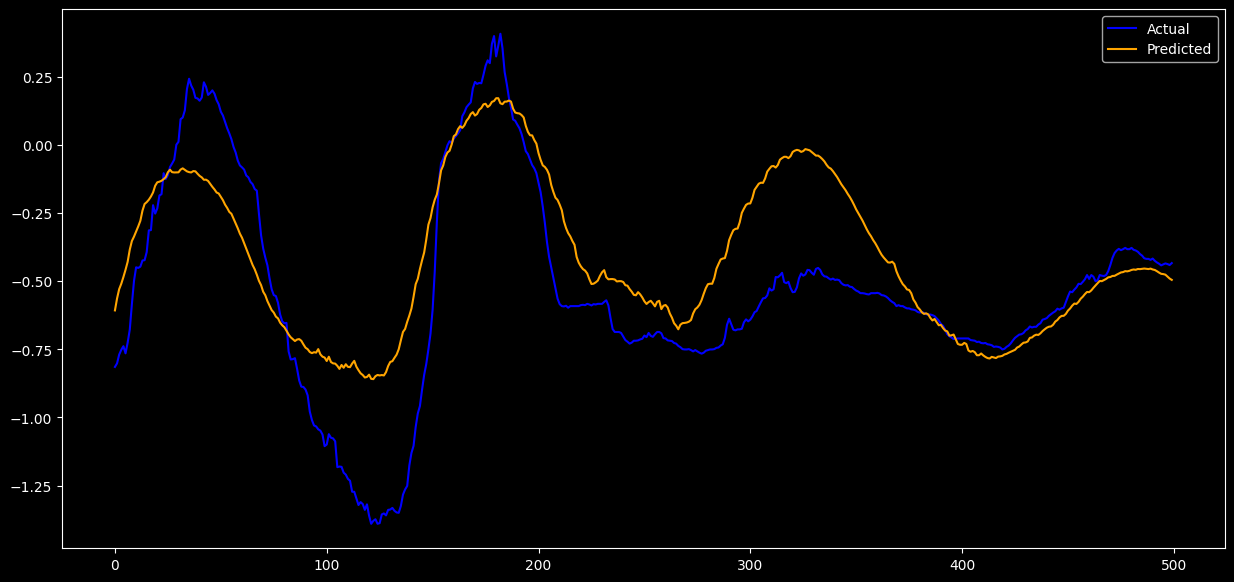

In [76]:
plt.figure(figsize=(15, 7))
plt.plot(y_test[:500], label='Actual', color='blue')
plt.plot(y_pred[:500], label='Predicted', color='orange')
plt.legend()
plt.show()

In [77]:
r2 = r2_score(y_test[:40550], y_pred)
print("R^2 Score:", r2)

R^2 Score: 0.8474534486997825
